<a href="https://colab.research.google.com/github/Jung0Jin/Python_Machine_Learning/blob/master/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EA%B5%90%EA%B3%BC%EC%84%9C6%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#6장 모델 평가와 하이퍼파라미터 튜닝의 모범 사례

* 편향되지 않은 모델 성능 추정하기

* 머신 러닝 알고리즘에서 일반적으로 발생하는 문제 분석하기

* 머신 러닝 모델 세부 튜닝하기

* 여러 가지 성능 지표를 사용하여 모델의 예측 성능 평가하기

##6.1 파이프라인을 사용한 효율적인 워크플로

앞장에서 전처리 기법을 배웠다. (4장에서 스케일을 조정하기 위한 표준화, 5장에서 데이터 압축을 위한 주성분 분석을 적용했다.) 

새로운 데이터 (예를 들면, 테스트 세트에 있는 별도의 샘플같은 새로운 데이터) 의 스케일을 조정하고 압축하기 위해 훈련 세트에서 학습한 파라미터를 재사용해야 한다고 배웠다.

여기서 유용하게 쓸 수 있는것이 사이킷런의 Pipeline 클래스이다.

여러 개의 변환 단계를 포함한 모델을 학습하고 새로운 데이터에 대한 예측을 만들 수 있다.



###6.1.1 위스콘신 유방암 데이터셋

위스콘신 유방암 데이터셋에는 악성과 양성인 종양 세포 샘플 569개가 포함되어 있다.

첫 두 열에는 샘플의 고유 ID 번호와 진단 결과(M=악성, B=양성)가 들어 있다.

3번째에서 32번째까지 열에는 세포 핵의 디지털 이미지에서 계산된 30개의 실수 값 특성이 들어 있다.

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                 header=None)

In [0]:
from sklearn.preprocessing import LabelEncoder

In [4]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y) # 클래스 레이블을 배열 y에 인코딩하기
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
le.transform(['M', 'B']) # 두 개의 더미 클래스 레이블 샘플로 LabelEncoder 객체의 transform 메서드를 호출하기

array([1, 0])

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=1)

###6.1.2 파이프라인으로 변환기와 추정기 연결

최적의 성능을 위해 입력 특성이 같은 스케일을 가져야 한다.

주성분 분석을 통해 초기 30차원에서 좀 더 낮은 2차원 부분 공간으로 데이터를 압축해보자

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [9]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear', random_state=1))
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=2,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [0]:
y_pred = pipe_lr.predict(X_test)

In [11]:
print(f'테스트 정확도 : {pipe_lr.score(X_test, y_test)}')

테스트 정확도 : 0.956140350877193


make_pipeline 함수는 여러 개의 사이킷런 변환기와 추정기를 연결할 수 있다.

변환기 : 입력에 대해 fit 메서드와 transform 메서드를 지원하는 객체

추정기 : fit 메서드와 predict 메서드를 구현함

make_pipeline 함수에 StandardScaler, PCA 두 개의 변환기와 LogisticRegression 추정기를 입력으로 넣는다. 이 함수는 이 객체들을 사용하여 Pipeline 클래스 객체를 생성하여 반환한다.

사이킷런의 Pipeline 클래스를 메타 추정기(meta-estimator)나 개별 변환기와 추정기를 감싼 래퍼(wrapper)로 생각할 수 있다.

Pipeline 객체의 fit 메서드를 호출하면 데이터가 중간 단계에 있는 모든 변환기의 fit 메서드와 transform 메서드를 차례로 거쳐 추정기 객체(파이프라인의 마지막 단계)에 도달한다. 추정기는 변환된 훈련 세트를 사용하여 학습한다.

앞선 예제에서 pipe_lr 파이프라인의 fit 메서드를 호출하면 StandardScaler의 fit 메서드와 transform 메서드가 호출된다. 변한된 훈련 데이터는 PCA 객체로 전달되어 fit 메서드와 transform 메서드가 호출된다. 최종적으로 추정기에 훈련 데이터가 전달된다.

파이프라인의 중간 단계 횟수는 제한이 없지만, 파이프라인의 마지막 요소는 추정기가 되어야 한다.

파이프라인은 predict 메서드도 제공하는데, Pipeline 인스턴스의 predict 메서드를 호출할 때 주입된 데이터는 중간 단계의 transform 메서드를 통과하여 마지막 단계에서 추정기 객체가 변환된 데이터에 대한 예측을 반환한다.

##6.2 k-겹 교차 검증을 사용한 모델 성능 평가

적절한 편향-분산 트레이드오프를 찾으려면 모델을 주의 깊게 평가해야 한다.

보편적인 교차 검증 기법으로 홀드아웃 교차 검증(holdout cross-validation)과 k-겹 교차 검증(k-fold cross-validation)이 있다.

###6.2.1 홀드아웃 방법

처음 본 데이터에서 예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교해야 한다.

이 과정을 모델 선택이라고 한다. 모델 선택이란 용어는 주어진 분류 문제에서 튜닝할 파라미터(또는 하이퍼파라미터)의 최적 값을 선택해야 하는 것을 의미한다. 

모델 선택에 같은 테스트 세트를 반복해서 재사용하면 훈련 세트의 일부가 되는 셈이니 이는 좋은 머신 러닝 작업 방식이 아니다.

가장 좋은 방법은 훈련 세트, 검증 세트, 테스트 세트 세 개의 부분으로 나누는 것이다.

훈련 세트로 여러 가지 모델을 훈련하는 데 사용한다.

검증 세트에 대한 성능은 모델 선택에 사용한다.

테스트 세트로 최종 성능을 평가한다.

단점 : 검증 세트의 성능 추정이 어떤 샘플을 사용하느냐에 따라 달라진다.

###6.2.2 k-겹 교차 검증

k-겹 교차 검증 : 

1. 중복 없이 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눈다. 

2. k-1개의 폴드로 모델을 훈련하고 나머지 하나의 폴드로 성능을 평가한다. 

3. 이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻는다. 

4. k개의 모델의 평균 성능을 계산한다.

일반적으로 모델 튜닝에 k-겹 교차 검증을 사용한다.

만족스러운 하이퍼파라미터 값을 찾은 후에 전체 훈련 세트를 사용하여 모델을 다시 훈련한다.

k-겹 교차 검증 후에 전체 훈련 세트로 모델을 학습하는 이유 : 훈련 샘플이 많을수록 학습 알고리즘이 더 정확하고 안정적인 모델을 만들기 때문이다.

k-겹 교차 검증이 중복을 허락하지 않는 리샘플링 기법이기 때문에 모든 샘플 포인트가 훈련하는 동안 검증에 딱 한 번 사용되는 장점이 있다. 이로 인해 홀드아웃 방법보다 모델 성능의 추정에 분산이 낮다. 

론 코하비는 10-겹 교차 검증이 편향-분산 트레이드오프를 가진다고 제안했다.

작은 훈련 세트는 폴드 개수인 k를 늘리는 것이 좋다. 모델 성능을 평균하여 일반화 성능을 추정할 때 더 낮은 편향을 만든다.

k 값이 아주 크면 교차 검증 알고리즘의 실행 시간이 늘어나고 분산이 높은 추정을 만든다. 이는 훈련 폴드가 서로 많이 비슷해지기 때문이다. 

대규모 데이터셋으로 작업할 때는 k=5와 같은 작은 k 값을 선택해도 모델의 평균 성능을 정확하게 추정할 수 있다. 폴드마다 모델을 학습하고 평가하는 계산 비용도 줄일 수 있다.

기본 k-겹 교차 검증 방법보다 좀 더 향상된 방법은 계층적 k-겹 교차 검증(stratified k-fold cross-validation)이다. 클래스 비율이 동등하지 않을 때, 클래스 비율이 전체 훈련 세트에 있는 클래스 비율을 대표하도록 유지한다.

In [0]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [13]:
kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(X_train,
                                              y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [0]:
scores=[]

In [15]:
for k, (train, test) in enumerate(kfold):
  pipe_lr.fit(X_train[train], y_train[train]) # 각 반복에서 샘플의 스케일을 조정한다.
  score = pipe_lr.score(X_train[test], y_train[test])
  scores.append(score)
  print(f'폴드 : {k+1}, 클래스 분포 : {np.bincount(y_train[train])}, 정확도 : {score}')

폴드 : 1, 클래스 분포 : [256 153], 정확도 : 0.9347826086956522
폴드 : 2, 클래스 분포 : [256 153], 정확도 : 0.9347826086956522
폴드 : 3, 클래스 분포 : [256 153], 정확도 : 0.9565217391304348
폴드 : 4, 클래스 분포 : [256 153], 정확도 : 0.9565217391304348
폴드 : 5, 클래스 분포 : [256 153], 정확도 : 0.9347826086956522
폴드 : 6, 클래스 분포 : [257 153], 정확도 : 0.9555555555555556
폴드 : 7, 클래스 분포 : [257 153], 정확도 : 0.9777777777777777
폴드 : 8, 클래스 분포 : [257 153], 정확도 : 0.9333333333333333
폴드 : 9, 클래스 분포 : [257 153], 정확도 : 0.9555555555555556
폴드 : 10, 클래스 분포 : [257 153], 정확도 : 0.9555555555555556


In [16]:
print(f'CV 정확도 : {np.mean(scores)} +/- {np.std(scores)}')

CV 정확도 : 0.9495169082125603 +/- 0.013854294239660376


In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)

In [19]:
print(f'CV 정확도 점수 : {scores}')

CV 정확도 점수 : [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [20]:
print(f'CV 정확도 : {np.mean(scores)} +/- {np.std(scores)}')

CV 정확도 : 0.9495169082125603 +/- 0.013854294239660376


cross_val_score 함수가 검증에 사용하는 지표 : 회귀일 때 R^2, 분류일 때 정확도

In [0]:
from sklearn.model_selection import cross_validate

In [0]:
scores = cross_validate(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        scoring=['accuracy'],
                        cv=10,
                        n_jobs=-1,
                        return_train_score=False)

In [23]:
print('CV 정확도 점수 : ', scores['test_accuracy'])

CV 정확도 점수 :  [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [24]:
print(f"CV 정확도 : {np.mean(scores['test_accuracy'])} +/- {np.std(scores['test_accuracy'])}")

CV 정확도 : 0.9495169082125603 +/- 0.013854294239660376


##6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

###6.3.1 학습 곡선으로 편향과 분산 문제 분석

편향이 높은 모델 : 훈련 정확도와 교차 검증 정확도가 모두 낮다. 훈련 데이터에 과소적합되었다. 해결하기 위해 모델의 파라미터 개수를 늘린다. 추가적인 특성을 수집하거나 만든다. 또는 SVM이나 로지스틱 회귀 분류기에서 규제 강도를 줄인다.

분산이 높은 모델 : 훈련 정확도와 교차 검증 정확도 사이에 큰 차이가 있다. 과대적합 문제를 해결하기 위해 더 많은 훈련 데이터를 모으거나 모델 복잡도를 낮추거나 규제를 증가시킨다. 규제가 없는 모델에서는 특성 선택이나 특성 추출을 통해 특성 개수를 줄여 과대적합을 감소한다. 

In [0]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [0]:
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear',
                                           penalty='l2',
                                           random_state=1))


In [0]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(
                                                            0.1, 1.0, 10), # 일정한 간격으로 훈련 세트의 비율 열 개를 설정
                                                        cv=10,
                                                        n_jobs=-1)

In [0]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

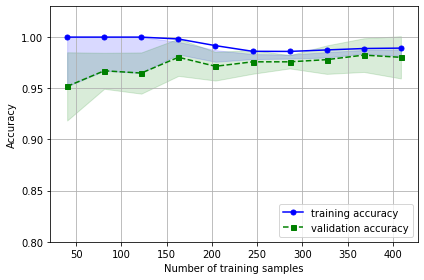

In [29]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 test_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

250개의 샘플 이상부터 잘 작동한다.

250개의 샘플보다 줄어들면 훈련 정확도는 증가하고 검증 정확도는 감소한다. 과대적합이다.

###6.3.2 검증 곡선으로 과대적합과 과소적합 조사

In [0]:
from sklearn.model_selection import validation_curve

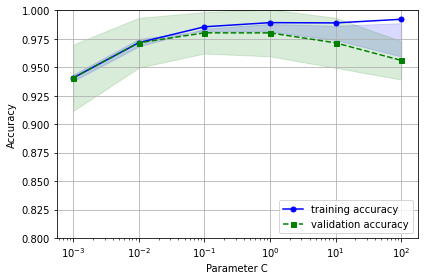

In [31]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name = 'logisticregression__C',
    param_range=param_range,
    cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(param_range,
                 test_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

C 값이 바뀜에 따라 정확도 차이가 미묘하지만 규제 강도를 높이면(C 값을 줄이면) 모델이 데이터에 조금 과소적합되는 것을 볼 수 있다.

규제 강도가 낮아지는 큰 C 값에서는 모델이 데이터에 조금 과대적합되는 경향을 보인다.

이 경우에 적절한 C 값은 0.01과 0.1 사이다.

##6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

###6.4.1 그리드 서치를 사용한 하이퍼파라미터 튜닝

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [0]:
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

In [0]:
param_range = [0.0001, 0.001, 0.01, 0.1,
               1.0, 10.0, 100.0, 1000.0]

In [0]:
param_grid = [{'svc__C': param_range,
               'svc__kernel' : ['linear']},
              {'svc__C': param_range,
               'svc__gamma' : param_range,
               'svc__kernel' : ['rbf']}]

In [0]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

In [0]:
gs = gs.fit(X_train, y_train)

In [38]:
print(gs.best_score_)

0.9846859903381642


In [39]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [40]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'테스트 정확도 : {clf.score(X_test, y_test)}')

테스트 정확도 : 0.9736842105263158


###6.4.2 중첩 교차 검증을 사용한 알고리즘 선택

여러 종류의 머신 러닝 알고리즘을 비교하려면 중첩 교차 검증(nested cross-validation) 방법이 권장된다.

중첩 교차 검증은 바깥쪽 k-겹 교차 검증 루프가 데이터를 훈련 폴드와 테스트 폴드로 나누고, 안쪽 루프가 훈련 폴드에서 k-겹 교차 검증을 수행하여 모델을 선택한다. 모델이 선택되면 테스트 폴드를 사용하여 모델 성능을 평가한다.

중첩 교차 검증은 계산 성능이 중요한 대용량 데이터셋에서 유용하다.

In [0]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

In [0]:
scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)

In [43]:
print(f'CV 정확도 : {np.mean(scores)} +/- {np.std(scores)}')

CV 정확도 : 0.9736263736263737 +/- 0.014906219743132467


In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(
    random_state=0
),
param_grid=[{'max_depth' : [1, 2, 3, 4, 5, 6, 7, None]}],
scoring='accuracy',
cv=2)

In [0]:
scores = cross_val_score(gs, X_train, y_train,
                         scoring='accuracy', cv=5)

In [47]:
print(f'CV 정확도 : {np.mean(scores)} +/- {np.std(scores)}')

CV 정확도 : 0.9340659340659341 +/- 0.015540808377726326


##6.5 여러 가지 성능 평가 지표

###6.5.1 오차 행렬

진짜 음성(Ture Negative, TN)   거짓 양성 (False Positive, FP)

거짓 음성 (False Negative, FN) 진짜 양성 (True Positive, TP)

In [0]:
from sklearn.metrics import confusion_matrix

In [49]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


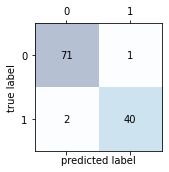

In [50]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i,
            s=confmat[i, j],
            va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

###6.5.2 분류 모델의 정밀도와 재현율 최적화

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

In [53]:
print(f'정밀도 : {precision_score(y_true=y_test, y_pred=y_pred)}')

정밀도 : 0.975609756097561


In [54]:
print(f'재현율 : {recall_score(y_true=y_test, y_pred=y_pred)}')

재현율 : 0.9523809523809523


In [55]:
print(f'F1 : {f1_score(y_true=y_test, y_pred=y_pred)}')

F1 : 0.963855421686747


In [0]:
from sklearn.metrics import make_scorer, f1_score

In [0]:
scorer = make_scorer(f1_score, pos_label=0)
c_gamma_range = [0.01, 0.1, 1.0, 10.0]

In [0]:
param_grid = [{'svc__C' : c_gamma_range,
               'svc__kernel' : ['linear']},
              {'svc__C' : c_gamma_range,
               'svc__gamma' : c_gamma_range,
               'svc__kernel' : ['rbf']}]

In [0]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv=10)

In [0]:
gs = gs.fit(X_train, y_train)

In [65]:
print(gs.best_score_)

0.9861994953378878


In [66]:
print(gs.best_params_)

{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


###6.5.3 ROC 곡선 그리기

ROC(Receiver Operation Characteristic) 그래프 : 분류기의 임계 값을 바꾸어 가며 계산된 FPR(거짓 양성 비율)과 TPR(진짜 양성 비율) 점수를 기반으로 분류 모델을 선택하는 도구

ROC 그래프의 대각선 : 랜덤 추측

ROC 그래프의 대각선 아래면 랜덤 추측보다 나쁜 셈

ROC 그래프의 왼쪽 위 구석은 완벽한 분류기

ROC 곡선의 아래 면적인 ROC AUC(ROC Area Under the Curve)를 계산하여 분류 모델의 성능을 종합한다.

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


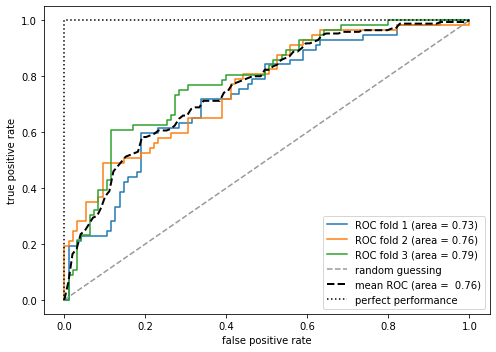

In [90]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear',
                                           penalty='l2',
                                           random_state=1,
                                           C=100.0))

X_train2 = X_train[:, [4,14]]

cv = list(StratifiedKFold(n_splits=3,
                          random_state=1).split(X_train,
                                                y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
  probas = pipe_lr.fit(X_train2[train],
                       y_train[train]).predict_proba(X_train2[test])
  fpr, tpr, thresholds = roc_curve(y_train[test],
                                   probas[:, 1],
                                   pos_label=1)                     
  mean_tpr += interp(mean_fpr, fpr, tpr)
  mean_tpr[0] = 0.0
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr,
          tpr,
          label='ROC fold %d (area = %0.2f)'
          % (i+1, roc_auc))
  
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
               label = 'mean ROC (area = % 0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

###6.5.4 다중 분류의 성능 지표

이진 분류 말고 다중 분류도 가능하다.

사이킷런은 평균 지표에 마크로(macro)와 마이크로(micro) 평균 방식을 구현하여 OvA(One-versus-All) 방식을 사용하는 다중 분류로 확장한다.

마이크로 평균 : 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용

마크로 평균 : 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가

In [0]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')

##6.6 불균형한 클래스 다루기

원래 유방암 데이터셋 : 212개의 악성 종양(클래스 1) 357개의 양성 종양(클래스 0)

357개의 양성 종양 샘플 전체와 40개의 악성 종양 샘플을 연결하여 불균형이 심한 데이터셋을 만들자.

In [0]:
X_imb = np.vstack((X[y==0], X[y==1][:40]))
y_imb = np.hstack((y[y==0], y[y==1][:40]))

In [94]:
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [0]:
from sklearn.utils import resample

In [97]:
print(f'샘플링하기 전 클래스 1의 샘플 개수 : {X_imb[y_imb == 1].shape[0]}')

샘플링하기 전 클래스 1의 샘플 개수 : 40


In [0]:
X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                    y_imb[y_imb == 1],
                                    replace = True,
                                    n_samples = X_imb[y_imb == 0].shape[0],
                                    random_state=123)

In [100]:
print(f'샘플링한 후 전 클래스 1의 샘플 개수 : {X_upsampled.shape[0]}')

샘플링한 후 전 클래스 1의 샘플 개수 : 357


In [0]:
X_bal = np.vstack((X[y==0], X_upsampled))
y_bal = np.hstack((y[y==0], y_upsampled))

In [102]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0